In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipaddress
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from imblearn.over_sampling import SMOTE

In [4]:
df = pd.read_csv("cybersecurity_attacks.csv", parse_dates=['Timestamp'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Timestamp               40000 non-null  datetime64[ns]
 1   Source IP Address       40000 non-null  object        
 2   Destination IP Address  40000 non-null  object        
 3   Source Port             40000 non-null  int64         
 4   Destination Port        40000 non-null  int64         
 5   Protocol                40000 non-null  object        
 6   Packet Length           40000 non-null  int64         
 7   Packet Type             40000 non-null  object        
 8   Traffic Type            40000 non-null  object        
 9   Payload Data            40000 non-null  object        
 10  Malware Indicators      20000 non-null  object        
 11  Anomaly Scores          40000 non-null  float64       
 12  Alerts/Warnings         19933 non-null  object

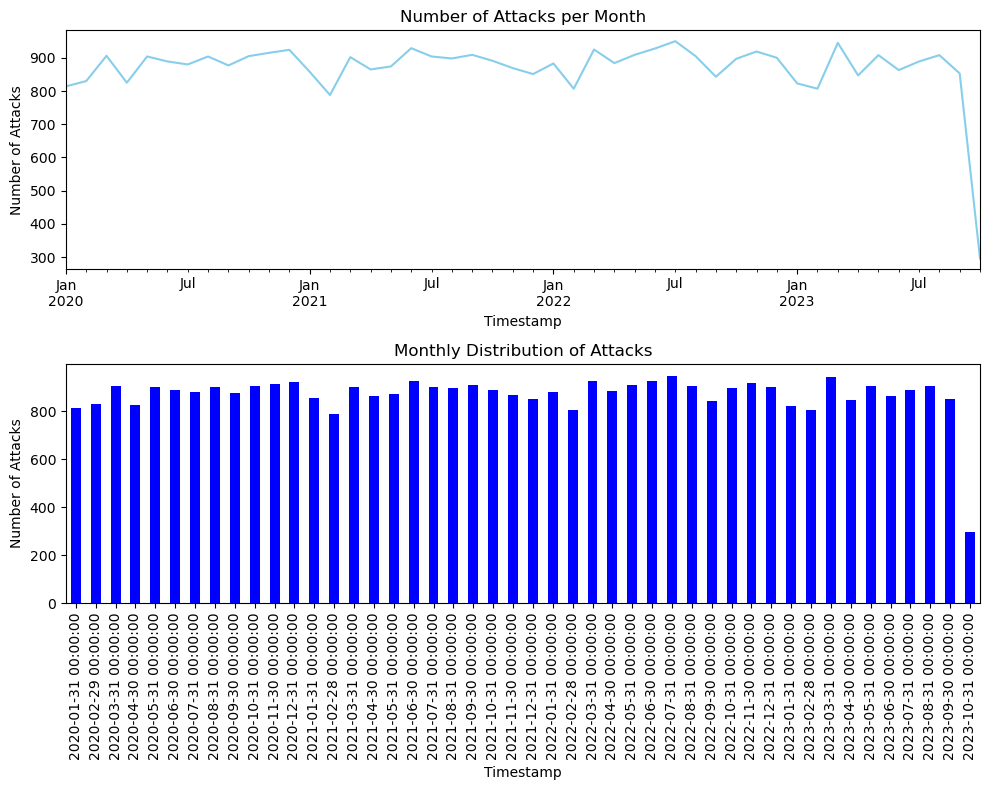

In [5]:
#Display the first 05 records in chosen dataset
df.head().T
#Dimension of the Dataset
print
("Dimension (No.of Rows, No.of Columns) of the Dataset: ", df.shape)
#Dataset Information: Dimension, Column Names & its count, data types
df.info()
#Dataset Description: Statistical summary for numerical columns of the dataset
df.describe().T
#Frequency of Attacks
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
monthly_attacks = df.resample('ME', on='Timestamp')['Attack Type'].count()
print("Information on Frequncy of Attacks")
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
monthly_attacks.plot(ax=ax[0], color='skyblue')
ax[0].set_title('Number of Attacks per Month')
ax[0].set_ylabel('Number of Attacks')
monthly_attacks.plot(kind='bar', ax=ax[1], color='blue')
ax[1].set_title('Monthly Distribution of Attacks')
ax[1].set_ylabel('Number of Attacks')
plt.tight_layout()
plt.show()

Summary of the No. of Attacks Year wise
 Attack Type  DDoS  Intrusion  Malware
Year                                 
2020         3533       3551     3489
2021         3545       3475     3518
2022         3558       3563     3629
2023         2792       2676     2671


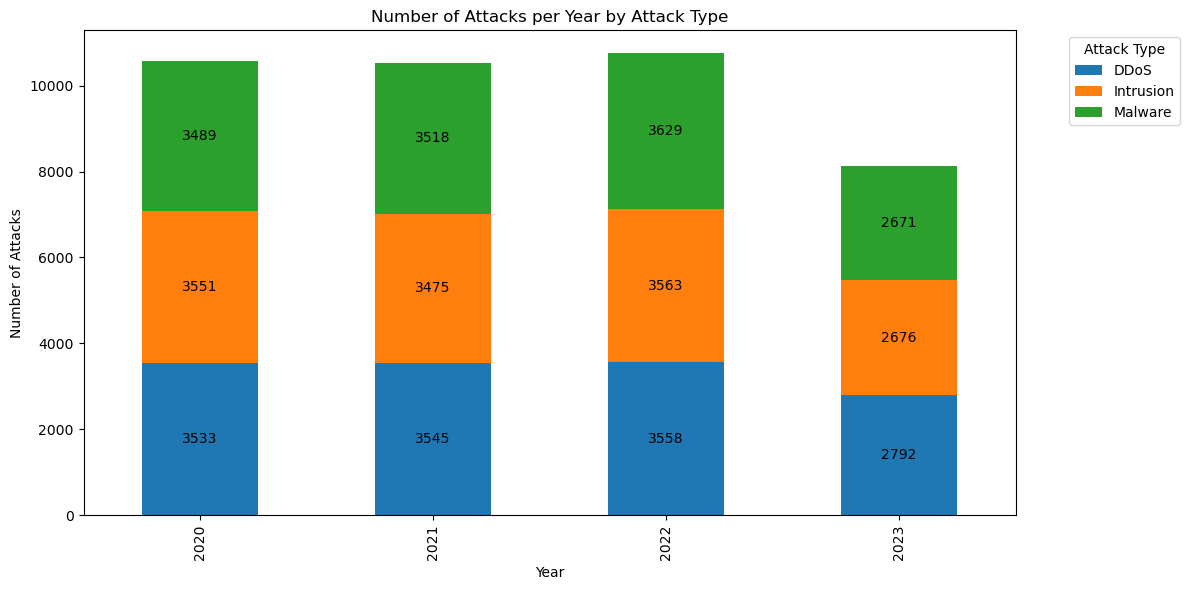

In [6]:
# Number of Attacks per year
df['Year'] = df['Timestamp'].dt.year

# Group by YEAR and ATTACK TYPE, count occurrences
attack_counts = df.groupby(['Year', 'Attack Type']).size().unstack(fill_value=0)

# Print a summary of the data
print("Summary of the No. of Attacks Year wise\n", attack_counts)

# Plot the data
ax = attack_counts.plot(kind='bar', stacked=True, figsize=(12, 6))

# Customize the plot
plt.title('Number of Attacks per Year by Attack Type')
plt.xlabel('Year')
plt.ylabel('Number of Attacks')
plt.legend(title='Attack Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Add value labels on the bars
for c in ax.containers:
    ax.bar_label(c, label_type='center')

# Show the plot
plt.show()

  Protocol Attack Type  COUNT
0     ICMP        DDoS   4508
6      UDP        DDoS   4482
2     ICMP     Malware   4461
1     ICMP   Intrusion   4460
3      TCP        DDoS   4438
5      TCP     Malware   4437
8      UDP     Malware   4409
7      UDP   Intrusion   4408
4      TCP   Intrusion   4397


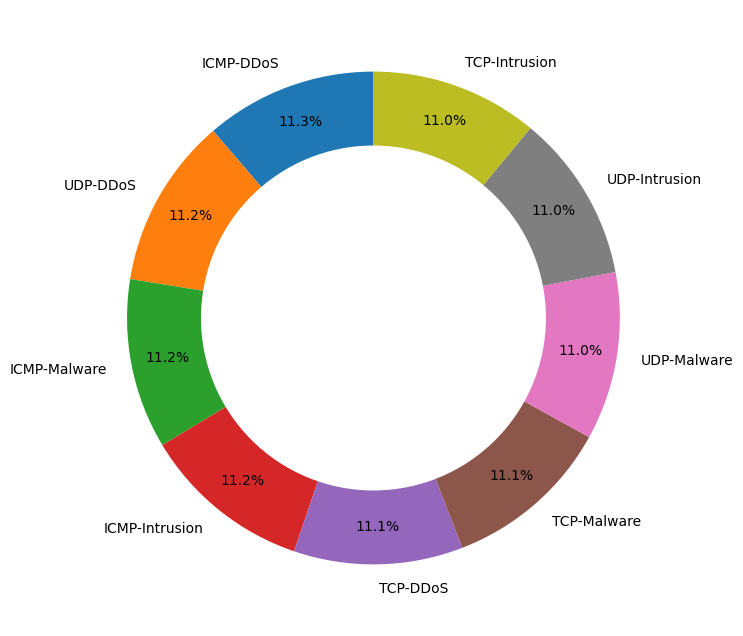

In [17]:
# Count occurrences of each combination of PROTOCOL and ATTACK TYPE
protocol_attack_counts = df.groupby(['Protocol', 'Attack Type']).size().reset_index(name='COUNT')

# Sort by count in descending order and take top 10 for better visibility
top_10 = protocol_attack_counts.sort_values('COUNT', ascending=False).head(10)

# Print a summary of the data
print(top_10)

# Create a pie chart
plt.figure(figsize=(12, 8))
plt.pie(
    top_10['COUNT'],
    labels=top_10.apply(lambda x: f"{x['Protocol']}-{x['Attack Type']}", axis=1),
    autopct='%1.1f%%',
    startangle=90,
    pctdistance=0.85
)

# Add a circle at the center to create a donut chart (optional)
center_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(center_circle)

plt.show()

C:\Users\Hamza Awarish\AppData\Local\Temp\ipykernel_21844\1763646756.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(


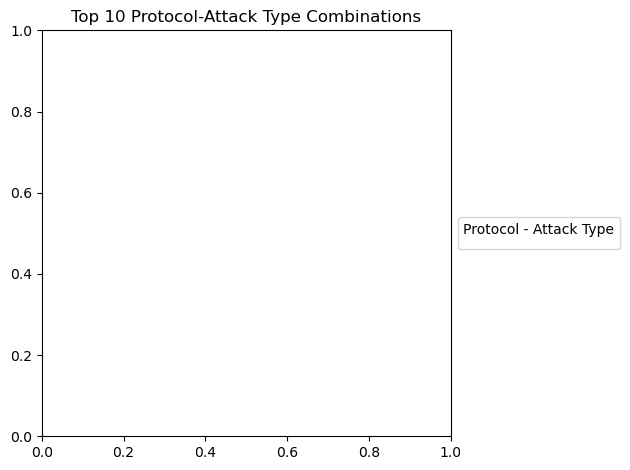

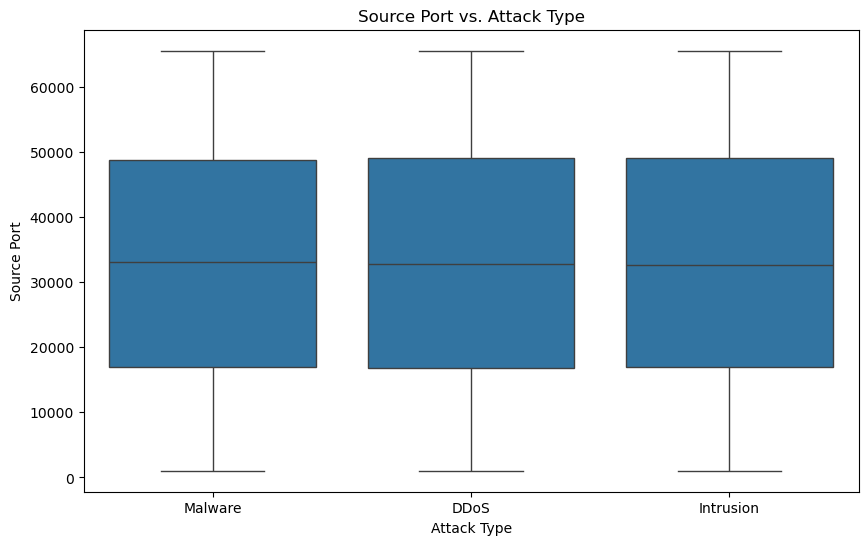

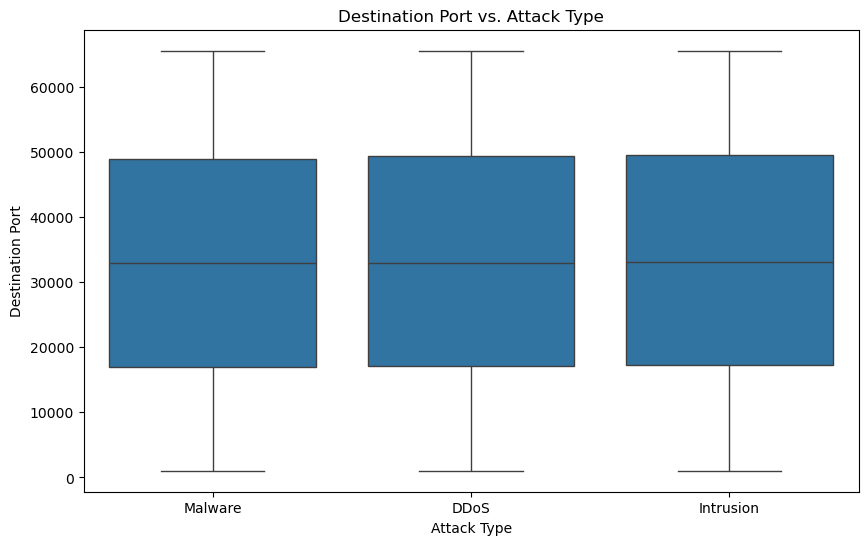

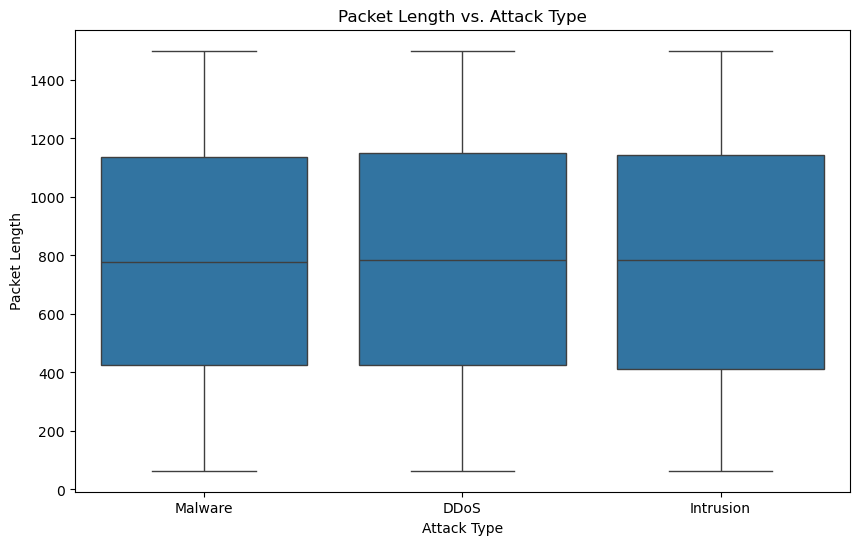

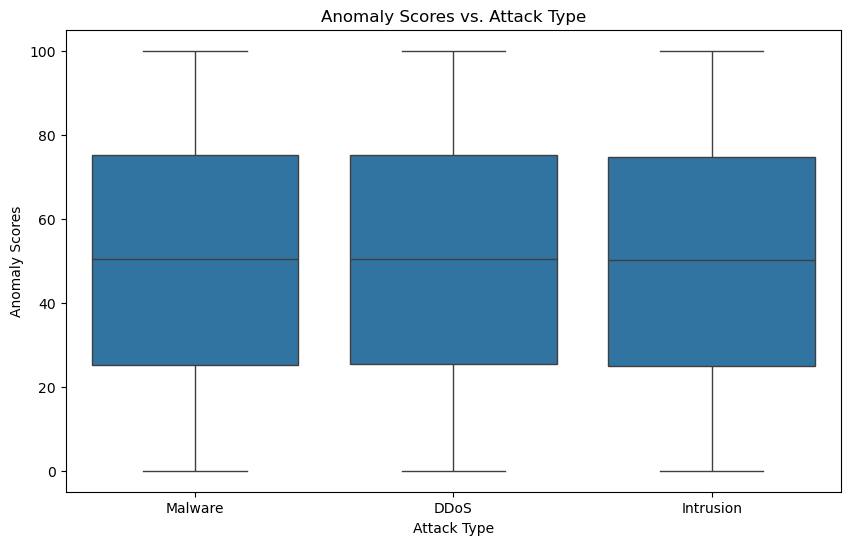

In [9]:
# Add title
plt.title('Top 10 Protocol-Attack Type Combinations')

# Add legend
plt.legend(
    title='Protocol - Attack Type',
    loc='center left',
    bbox_to_anchor=(1, 0, 0.5, 1)
)

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.show()

# Explore relationships between features and the target variable
# Select some features for visualization. Adjust based on actual features in your dataset.
features = ['Source Port', 'Destination Port', 'Packet Length', 'Anomaly Scores']

for feature in features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Attack Type', y=feature, data=df)
    plt.title(f'{feature} vs. Attack Type')
    plt.xlabel('Attack Type')
    plt.ylabel(feature)
    plt.show()

In [13]:
# Handling Missing Values: Identify the columns with missing values and fill with 0
# Get column names with missing values
columns_with_missing = df.columns[df.isnull().any()].tolist()

# Print the result
print("Columns with missing values:")
for column in columns_with_missing:
    print(column)

# If you want to also see the count of missing values:
print("\nColumns with missing values and their counts:")
for column in columns_with_missing:
    missing_count = df[column].isnull().sum()
    print(f"{column}: {missing_count}")

# Fill the missing values with 0
df = df.fillna(0)
df.info()

Columns with missing values:
Malware Indicators
Alerts/Warnings
Proxy Information
Firewall Logs
IDS/IPS Alerts

Columns with missing values and their counts:
Malware Indicators: 20000
Alerts/Warnings: 20067
Proxy Information: 19851
Firewall Logs: 19961
IDS/IPS Alerts: 20050
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Timestamp               40000 non-null  datetime64[ns]
 1   Source IP Address       40000 non-null  object        
 2   Destination IP Address  40000 non-null  object        
 3   Source Port             40000 non-null  int64         
 4   Destination Port        40000 non-null  int64         
 5   Protocol                40000 non-null  object        
 6   Packet Length           40000 non-null  int64         
 7   Packet Type             40000 non-null  object        
 8   Traffic Typ

In [19]:
import pandas as pd
import ipaddress

# Assuming df['Timestamp'] is already in 'YYYY-MM-DD HH:MM:SS' format
print("Timestamp values in YYYY-MM-DD HH:MM:SS format:\n", df['Timestamp'])

# Convert the 'Timestamp' column to UNIX Epoch time (seconds since 1970-01-01)
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Timestamp'] = df['Timestamp'].view('int64') // 10**9

# Print the updated DataFrame
print("Converted Timestamp to UNIX Epoch time:\n", df['Timestamp'])

# Convert the IP Addresses ('Source IP Address' & 'Destination IP Address') to integers
print("Before conversion, the IP Addresses in the Dataset:\n", df.head())

# Function to convert IP to integer
def ip_to_int(ip):
    return int(ipaddress.ip_address(ip))

# Apply the conversion to IP address columns
df['Destination IP Address'] = df['Destination IP Address'].apply(ip_to_int)
df['Source IP Address'] = df['Source IP Address'].apply(ip_to_int)

print("After conversion, the IP Addresses in the Dataset:\n", df.head())

# Display the first 2 rows transposed
df.head(2).T

Timestamp values in YYYY-MM-DD HH:MM:SS format:
 0       2023-05-30 06:33:58
1       2020-08-26 07:08:30
2       2022-11-13 08:23:25
3       2023-07-02 10:38:46
4       2023-07-16 13:11:07
                ...        
39995   2023-05-26 14:08:42
39996   2023-03-27 00:38:27
39997   2022-03-31 01:45:49
39998   2023-09-22 18:32:38
39999   2023-10-10 11:59:52
Name: Timestamp, Length: 40000, dtype: datetime64[ns]
Converted Timestamp to UNIX Epoch time:
 0        1685428438
1        1598425710
2        1668327805
3        1688294326
4        1689513067
            ...    
39995    1685110122
39996    1679877507
39997    1648691149
39998    1695407558
39999    1696939192
Name: Timestamp, Length: 40000, dtype: int64
Before conversion, the IP Addresses in the Dataset:
     Timestamp Source IP Address Destination IP Address  Source Port  \
0  1685428438     103.216.15.12           84.9.164.252        31225   
1  1598425710    78.199.217.198         66.191.137.154        17245   
2  1668327805    

C:\Users\Hamza Awarish\AppData\Local\Temp\ipykernel_21844\4042505836.py:9: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  df['Timestamp'] = df['Timestamp'].view('int64') // 10**9


After conversion, the IP Addresses in the Dataset:
     Timestamp  Source IP Address  Destination IP Address  Source Port  \
0  1685428438         1742212876              1409918204        31225   
1  1598425710         1321720262              1119848858        17245   
2  1668327805         1062195760              3336262161        16811   
3  1688294326         2737488906              1709490431        20018   
4  1689513067         1202108748              3186863854         6131   

   Destination Port Protocol  Packet Length Packet Type Traffic Type  \
0             17616     ICMP            503        Data         HTTP   
1             48166     ICMP           1174        Data         HTTP   
2             53600      UDP            306     Control         HTTP   
3             32534      UDP            385        Data         HTTP   
4             26646      TCP           1462        Data          DNS   

                                        Payload Data  ... Severity Level  \


,0,1
Timestamp,1685428438,1598425710
Source IP Address,1742212876,1321720262
Destination IP Address,1409918204,1119848858
Source Port,31225,17245
Destination Port,17616,48166
Protocol,ICMP,ICMP
Packet Length,503,1174
Packet Type,Data,Data
Traffic Type,HTTP,HTTP
Payload Data,Qui natus odio asperiores nam. Optio nobis ius...,Aperiam quos modi officiis veritatis rem. Omni...


In [21]:
# Replace certain values with 1 for the columns where Firewall Logs value is 'Log Data', Malware Indicators value is 'IoC Detected', and Alerts/Warnings value is 'Alert Triggered'
df['Firewall Logs'] = df['Firewall Logs'].replace('Log Data', 1)
df['Malware Indicators'] = df['Malware Indicators'].replace('IoC Detected', 1)
df['Alerts/Warnings'] = df['Alerts/Warnings'].replace('Alert Triggered', 1)

print("After replacing certain values of columns: Firewall Logs, Malware Indicators & Alerts/Warnings with 1,\n")
df.head(2).T

After replacing certain values of columns: Firewall Logs, Malware Indicators & Alerts/Warnings with 1,



C:\Users\Hamza Awarish\AppData\Local\Temp\ipykernel_21844\1298962354.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Firewall Logs'] = df['Firewall Logs'].replace('Log Data', 1)
C:\Users\Hamza Awarish\AppData\Local\Temp\ipykernel_21844\1298962354.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Malware Indicators'] = df['Malware Indicators'].replace('IoC Detected', 1)
C:\Users\Hamza Awarish\AppData\Local\Temp\ipykernel_21844\1298962354.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be 

,0,1
Timestamp,1685428438,1598425710
Source IP Address,1742212876,1321720262
Destination IP Address,1409918204,1119848858
Source Port,31225,17245
Destination Port,17616,48166
Protocol,ICMP,ICMP
Packet Length,503,1174
Packet Type,Data,Data
Traffic Type,HTTP,HTTP
Payload Data,Qui natus odio asperiores nam. Optio nobis ius...,Aperiam quos modi officiis veritatis rem. Omni...


In [23]:
# Drop columns: IDS/IPS Alerts and Proxy Information as these two features have no valid contribution in our model
print("Dimension of Chosen Dataset: ", df.shape)
df = df.drop(columns=['IDS/IPS Alerts', 'Proxy Information', 'Year'])
print("Processed Dataset Dimension is: ", df.shape)

Dimension of Chosen Dataset:  (40000, 26)
Processed Dataset Dimension is:  (40000, 23)


In [25]:
# Hot Encoding or Label Encoding, converting the categorical values into numerical values
le = LabelEncoder()
df['Attack Type'] = le.fit_transform(df['Attack Type'])
df['Log Source'] = le.fit_transform(df['Log Source'])
df['Attack Signature'] = le.fit_transform(df['Attack Signature'])
df['Action Taken'] = le.fit_transform(df['Action Taken'])
df['Severity Level'] = le.fit_transform(df['Severity Level'])
df['User Information'] = le.fit_transform(df['User Information'])
df['Device Information'] = le.fit_transform(df['Device Information'])
df['Network Segment'] = le.fit_transform(df['Network Segment'])
df['Protocol'] = le.fit_transform(df['Protocol'])
df['Geo-location Data'] = le.fit_transform(df['Geo-location Data'])
df['Packet Type'] = le.fit_transform(df['Packet Type'])
df['Traffic Type'] = le.fit_transform(df['Traffic Type'])
df['Payload Data'] = le.fit_transform(df['Payload Data'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Timestamp               40000 non-null  int64  
 1   Source IP Address       40000 non-null  int64  
 2   Destination IP Address  40000 non-null  int64  
 3   Source Port             40000 non-null  int64  
 4   Destination Port        40000 non-null  int64  
 5   Protocol                40000 non-null  int32  
 6   Packet Length           40000 non-null  int64  
 7   Packet Type             40000 non-null  int32  
 8   Traffic Type            40000 non-null  int32  
 9   Payload Data            40000 non-null  int32  
 10  Malware Indicators      40000 non-null  int64  
 11  Anomaly Scores          40000 non-null  float64
 12  Alerts/Warnings         40000 non-null  int64  
 13  Attack Type             40000 non-null  int32  
 14  Attack Signature        40000 non-null

In [27]:
# Calculate the number of attacks using class variable: Attack Type
if 'Attack Type' in df.columns:
    attack_counts = df['Attack Type'].value_counts()
    if not attack_counts.empty:
        le = LabelEncoder()
        le.fit(df['Attack Type'])
        class_names = le.inverse_transform(attack_counts.index)
        print("Attacks detected:")
        attack_counts = df['Attack Type'].value_counts()
        num_unique_attack_types = attack_counts.nunique()
        print(f"Number of unique Attack Types: {num_unique_attack_types}")
        class_names = {0: "DDoS", 1: "Intrusion", 2: "Malware"}
        print("Unique Attack Types and their Counts:")
        for attack_type, count in attack_counts.items():
            class_name = class_names.get(attack_type, "Unknown Class")
            print(f"{class_name} ({attack_type}): {count}")

Attacks detected:
Number of unique Attack Types: 3
Unique Attack Types and their Counts:
DDoS (0): 13428
Malware (2): 13307
Intrusion (1): 13265


In [29]:
# Separate the Feature Variables (X) and Target/Class Variables (y) in the Chosen Dataset
print("Dimension of the Dataset:", df.shape)
X = df.drop(columns=['Attack Type'])
y = df['Attack Type']
print("Dimension of Feature Variables (X):", X.shape, "Dimension of Target Variable (y):", y.shape)

# Data balancing using SMOTE and Data Augmentation
target_size = 200000
class_counts = y.value_counts().to_dict()
total_samples_needed = target_size - len(y)
samples_per_class = {cls: count + total_samples_needed // len(class_counts) for cls, count in class_counts.items()}
smote = SMOTE(sampling_strategy=samples_per_class, random_state=42)
X_res, y_res = smote.fit_resample(X, y)

def add_noise(dataframe, noise_level=0.01):
    noise = np.random.randn(*dataframe.shape) * noise_level
    dataframe_noisy = dataframe + noise
    return dataframe_noisy

numerical_columns = X_res.select_dtypes(include=[np.number]).columns
X_res_noisy = add_noise(X_res[numerical_columns])
X_augmented = pd.concat([X_res, X_res_noisy], ignore_index=True)
y_augmented = pd.concat([y_res, y_res], ignore_index=True)

df_resampled = X_augmented.copy()
df_resampled['Attack Type'] = y_augmented
df_resampled.info()

Dimension of the Dataset: (40000, 23)
Dimension of Feature Variables (X): (40000, 22) Dimension of Target Variable (y): (40000,)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399998 entries, 0 to 399997
Data columns (total 23 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Timestamp               399998 non-null  float64
 1   Source IP Address       399998 non-null  float64
 2   Destination IP Address  399998 non-null  float64
 3   Source Port             399998 non-null  float64
 4   Destination Port        399998 non-null  float64
 5   Protocol                399998 non-null  float64
 6   Packet Length           399998 non-null  float64
 7   Packet Type             399998 non-null  float64
 8   Traffic Type            399998 non-null  float64
 9   Payload Data            399998 non-null  float64
 10  Malware Indicators      399998 non-null  float64
 11  Anomaly Scores          399998 non-null  float64
 12 

Number of Attack Classes: [2 0 1]

Number of Samples for each Attack Class: Attack Type
0    133522
2    133280
1    133196
Name: count, dtype: int64


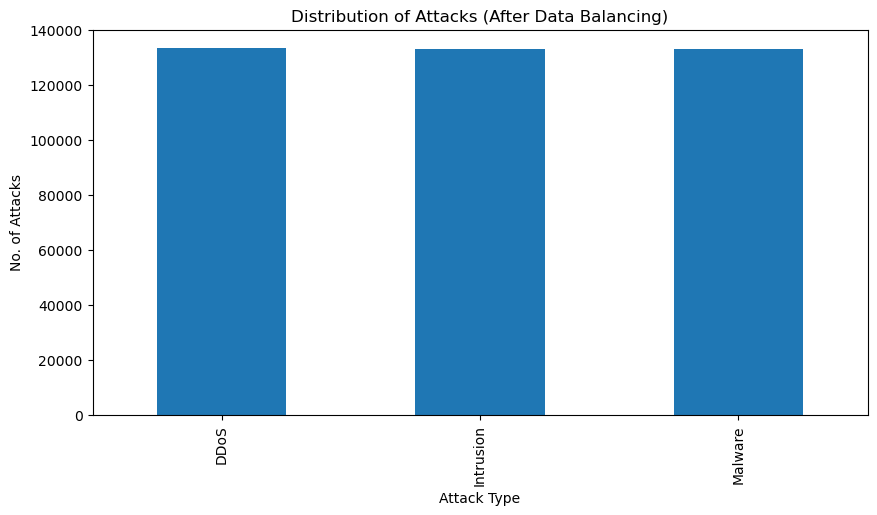

In [31]:
# Number of Attack classes after Data Balancing
print("Number of Attack Classes:", df_resampled['Attack Type'].unique())
print("\nNumber of Samples for each Attack Class:", df_resampled['Attack Type'].value_counts())

# Plotting the data samples after DATA BALANCING using SMOTE
plt.figure(figsize=(10, 5))
df_resampled['Attack Type'].value_counts().plot(kind='bar')
plt.xticks([0, 1, 2], ['DDoS', 'Intrusion', 'Malware'])
plt.ylabel('No. of Attacks')
plt.title("Distribution of Attacks (After Data Balancing)")
plt.show()

In [33]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    df_resampled.drop(columns=['Attack Type']),
    df_resampled['Attack Type'],
    test_size=0.2
)
print("After Splitting the Dataset,\nDimensions of TRAINING SET:", X_train.shape, y_train.shape)
print("Dimensions of TESTING SET:", X_test.shape, y_test.shape)
X_train.head(2)
y_train.head(2)
X_test.head(2)
y_test.head(2)

After Splitting the Dataset,
Dimensions of TRAINING SET: (319998, 22) (319998,)
Dimensions of TESTING SET: (80000, 22) (80000,)


116377    1
255689    0
Name: Attack Type, dtype: int32

In [35]:
# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert labels to categorical format
num_classes = len(np.unique(y_train))
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

print("After Feature Scaling,\nDimensions of TRAINING SET:", X_train.shape, y_train.shape)
print("Dimensions of TESTING SET:", X_test.shape, y_test.shape)

After Feature Scaling,
Dimensions of TRAINING SET: (319998, 22) (319998, 3)
Dimensions of TESTING SET: (80000, 22) (80000, 3)


## Problem: Based on the above code divide your data into three different sets - Training, Validation, and Test.

In [43]:
# Importing required modules
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler

# First split: Training + Validation / Test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    df_resampled.drop(columns=['Attack Type']),
    df_resampled['Attack Type'],
    test_size=0.2,  # Test size is 20% of the data
    random_state=42
)

# Second split: Training / Validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size=0.25,  # Validation size is 25% of the training data (which is 20% of the total data)
    random_state=42
)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Convert labels to categorical format
num_classes = len(np.unique(y_train))
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)

# Print the dimensions of the datasets
print("Dimensions of TRAINING SET:", X_train.shape, y_train.shape)
print("Dimensions of VALIDATION SET:", X_val.shape, y_val.shape)
print("Dimensions of TESTING SET:", X_test.shape, y_test.shape)

Dimensions of TRAINING SET: (239998, 22) (239998, 3)
Dimensions of VALIDATION SET: (80000, 22) (80000, 3)
Dimensions of TESTING SET: (80000, 22) (80000, 3)
